<a href="https://colab.research.google.com/github/alinchet/NLP-disaster-tweets/blob/main/nlp_disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q --upgrade keras-nlp keras

# Configure backend
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.4 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras_nlp
from sklearn.model_selection import train_test_split

print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")

# Check GPU
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("✅ GPU Detected. Enabling Mixed Precision.")
    keras.mixed_precision.set_global_policy("mixed_float16")
else:
    print("⚠️ Running on CPU (Did you select T4 GPU in Runtime settings?)")

# data
try:
    df_train = pd.read_csv("train.csv")
    df_test = pd.read_csv("test.csv")
except FileNotFoundError:
    print("❌ Error: Please upload train.csv and test.csv to the Files tab on the left!")

# Data Prep
X = df_train["text"]
y = df_train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test["text"]


/usr/local/lib/python3.12/dist-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow: 2.19.0
Keras: 3.13.0
✅ GPU Detected. Enabling Mixed Precision.


Training Samples: 7613
Test Samples: 3263


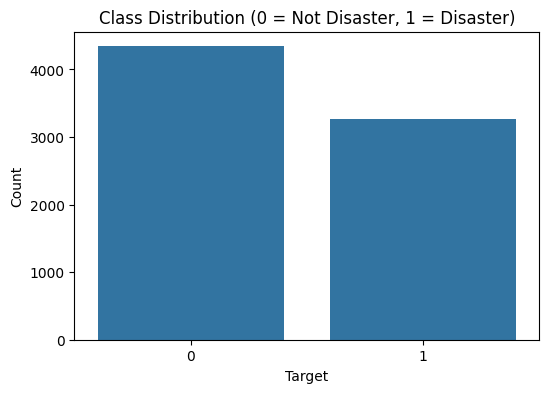

Real Disasters: 3271 (42.97%)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- EDA: Class Balance ---
print(f"Training Samples: {len(df_train)}")
print(f"Test Samples: {len(df_test)}")

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_train)
plt.title('Class Distribution (0 = Not Disaster, 1 = Disaster)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Calculate balance
real_disaster_count = df_train['target'].sum()
print(f"Real Disasters: {real_disaster_count} ({real_disaster_count/len(df_train):.2%})")

In [ ]:
# --- ici ça train ---
def train_experiment(learning_rate, name):
    print(f"\n--- Training: {name} (LR: {learning_rate}) ---")

    # pick distilBert
    preset = "distil_bert_base_en_uncased"

    print(f"Loading {preset} (this will take a minute)...")
    preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160)
    classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor=preprocessor, num_classes=2)

    classifier.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=keras.optimizers.Adam(learning_rate),
        metrics=["accuracy"]
    )

    # 2. Define Checkpoints, avoid overfitting
    model_filename = f"best_model_{name}.keras"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=model_filename,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1
    )

    # 3. Train (Increased to 5 Epochs)
    history = classifier.fit(
        x=X_train, y=y_train,
        batch_size=32,
        epochs=5,  # Increased from 3 to 5
        validation_data=(X_val, y_val),
        callbacks=[checkpoint],
        verbose=1
    )

    # 4. Load best model
    print(f"Loading best model from {model_filename}...")
    best_model = keras.models.load_model(model_filename)

    return history, best_model

# --- EXP ---
if len(X_train) > 0:
    # Experiment 1: Standard Conservative Learning Rate
    print("here")
    hist_base, model_base = train_experiment(2e-5, "Baseline")

    # Experiment 2: Optimized Higher Learning Rate for DistilBERT
    print ("here2")
    hist_high, model_high = train_experiment(5e-5, "High_LR")
else:
    print("⚠️ Pas de données d'entraînement. Avez-vous uploadé les fichiers CSV ?")

here

--- Training: Baseline (LR: 2e-05) ---
Loading distil_bert_base_en_uncased (this will take a minute)...
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7557 - loss: 0.5152
Epoch 1: val_accuracy improved from None to 0.84373, saving model to best_model_Baseline.keras

Epoch 1: finished saving model to best_model_Baseline.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 129s 413ms/step - accuracy: 0.7984 - loss: 0.4557 - val_accuracy: 0.8437 - val_loss: 0.3854
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8569 - loss: 0.3610
Epoch 2: val_accuracy improved from 0.84373 to 0.84504, saving model to best_model_Baseline.keras

Epoch 2: finished saving model to best_model_Baseline.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 53s 274ms/step - accuracy: 0.8580 - loss: 0.3520 - val_accuracy: 0.8450 - val_loss: 0.3813
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8912 - loss: 0.2841
Epoch 3: val_accuracy did not improve from 0.84504
191/191 ━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/saving/serialization_lib.py:749: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 214 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 210 variables. 
  saveable.load_own_variables(weights_store.get(inner_pa

here2

--- Training: High_LR (LR: 5e-05) ---
Loading distil_bert_base_en_uncased (this will take a minute)...
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7805 - loss: 0.4921
Epoch 1: val_accuracy improved from None to 0.83651, saving model to best_model_High_LR.keras

Epoch 1: finished saving model to best_model_High_LR.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 128s 417ms/step - accuracy: 0.8071 - loss: 0.4436 - val_accuracy: 0.8365 - val_loss: 0.3859
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8688 - loss: 0.3266
Epoch 2: val_accuracy did not improve from 0.83651
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.8765 - loss: 0.3105 - val_accuracy: 0.8253 - val_loss: 0.4278
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9140 - loss: 0.2265
Epoch 3: val_accuracy did not improve from 0.83651
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - accuracy: 0.9176 - loss: 0.2200 - val_accuracy: 0.8201 - val_loss: 0.4934
Epoch 4/5
19

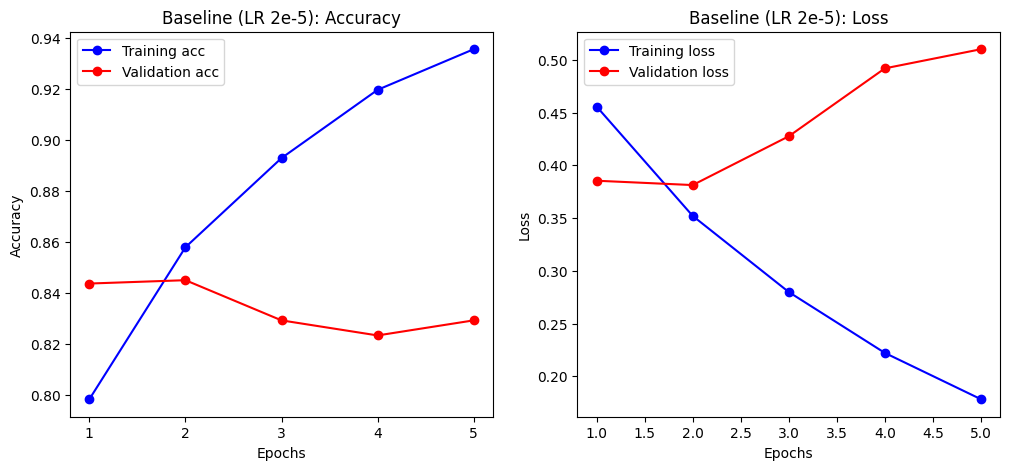

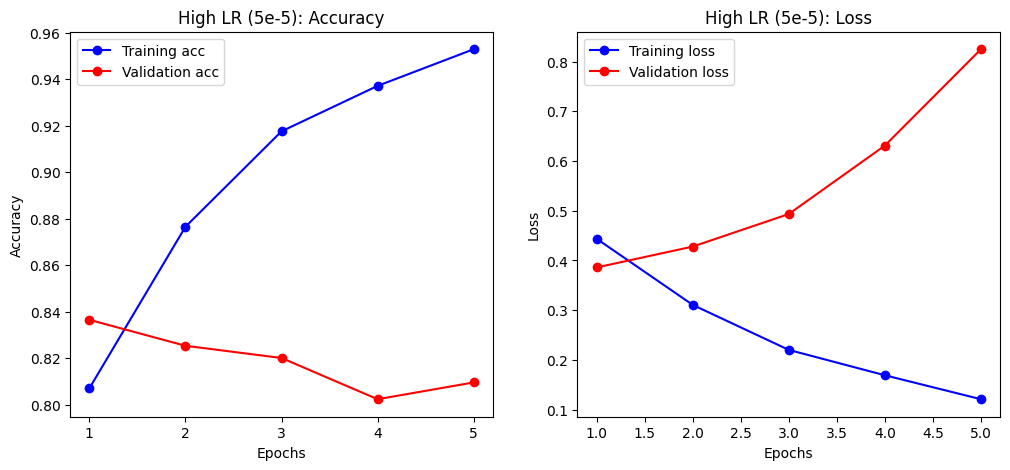

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# --- PLOTTING TRAINING RESULTS ---
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    ax = plt.subplot(1, 2, 1)  # <--- FIXED LINE (Removed 'fig, ')
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{model_name}: Accuracy')
    plt.xlabel('Epochs')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{model_name}: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Visualize both experiments
# (These variables should still be in memory if you haven't restarted)
if 'hist_base' in locals():
    plot_history(hist_base, "Baseline (LR 2e-5)")
    plot_history(hist_high, "High LR (5e-5)")
else:
    print("Training history not found. You might need to re-run the training cell (Cell 16).")

--- Evaluating Best Model on Validation Set ---
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step


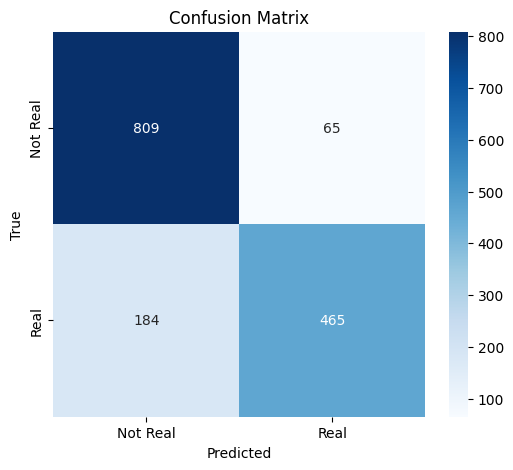

              precision    recall  f1-score   support

    Not Real       0.81      0.93      0.87       874
        Real       0.88      0.72      0.79       649

    accuracy                           0.84      1523
   macro avg       0.85      0.82      0.83      1523
weighted avg       0.84      0.84      0.83      1523



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on Validation Set (Ground Truth is available)
print("--- Evaluating Best Model on Validation Set ---")
val_predictions = model_high.predict(X_val) # Use your best model here
val_preds_classes = np.argmax(val_predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_val, val_preds_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Real', 'Real'], yticklabels=['Not Real', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision/Recall)
print(classification_report(y_val, val_preds_classes, target_names=['Not Real', 'Real']))

In [ ]:
import numpy as np
import pandas as pd
import shutil

# --- SELECT & SAVE BEST MODEL ---

# safety
if 'hist_base' in locals() and 'hist_high' in locals():
    acc_base = max(hist_base.history['val_accuracy'])
    acc_high = max(hist_high.history['val_accuracy'])

    print(f"Baseline Accuracy: {acc_base:.4%}")
    print(f"High LR Accuracy:  {acc_high:.4%}")

    # 2. Winner
    if acc_base > acc_high:
        print("\n🏆 WINNER: Baseline Model (LR 2e-5)")
        final_model = model_base
        best_file = "best_model_Baseline.keras"
    else:
        print("\n🏆 WINNER: High LR Model (LR 1e-4)")
        final_model = model_high
        best_file = "best_model_High_LR.keras"

    # 3. Save
    final_name = "final_best_model.keras"
    final_model.save(final_name)
    print(f"Saved best model to: {final_name}")

    # 4. Submission (for kaggle)
    print("Generating predictions...")
    pred = final_model.predict(X_test)

    # dataframe!
    sub = pd.DataFrame()
    sub['id'] = df_test['id']
    sub['target'] = np.argmax(pred, axis=1)

    sub.to_csv("submission_final.csv", index=False)
    print("✅ Success! 'submission.csv' generated using the best model.")

else:
    print("❌ Error: Training history variables not found. Did you run the training cell above?")

Baseline Accuracy: 84.5043%
High LR Accuracy:  83.6507%

🏆 WINNER: Baseline Model (LR 2e-5)
Saved best model to: final_best_model.keras
Generating predictions...
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step
✅ Success! 'submission.csv' generated using the best model.


In [ ]:
# Create a DataFrame of errors
val_df = pd.DataFrame({'text': X_val, 'true': y_val, 'pred': val_preds_classes})
val_df['prob_real'] = tf.nn.softmax(val_predictions)[:, 1] # Probability score

# False Positives: Model said Real (1), Truth was Fake (0)
# Imo annotation mistakes
fp = val_df[(val_df['pred'] == 1) & (val_df['true'] == 0)].sort_values(by='prob_real', ascending=False)

print("\n=== TOP FALSE POSITIVES (Metaphors?) ===")
for i, row in fp.head(5).iterrows():
    print(f"\nConfidence: {row['prob_real']:.4f}")
    print(f"Tweet: {row['text']}")

# False Negatives: Model said Fake (0), Truth was Real (1)
# - usually mistake too
fn = val_df[(val_df['pred'] == 0) & (val_df['true'] == 1)].sort_values(by='prob_real', ascending=True)

print("\n=== TOP FALSE NEGATIVES (Missed Disasters) ===")
for i, row in fn.head(5).iterrows():
    print(f"\nConfidence: {row['prob_real']:.4f}")
    print(f"Tweet: {row['text']}")


=== TOP FALSE POSITIVES (Metaphors?) ===

Confidence: 0.9741
Tweet: @adorableappple No reported flooding po in the area. Ten-4. #mmda

Confidence: 0.9209
Tweet: OMG OMG OMG #JustinBieber and #HarryStyles have collided in a nuclear accident at #Cern ^oo^

#HarryBeCareful http://t.co/p4huQUNDQi

Confidence: 0.9199
Tweet: Russian customs destroyed a total of 319 tons of food today phew! Some Italian meats were burned in an incinerator in Pulkovo airport.

Confidence: 0.9185
Tweet: Video Captures Man Removing American Flag From Long Beach CA Home Burning It; Arsonist Sought http://t.co/JP2QlrunjJ http://t.co/jbpgkGOwSi

Confidence: 0.9048
Tweet: Over half of poll respondents worry nuclear disaster fading from public consciousness http://t.co/YtnnnD631z ##fukushima

=== TOP FALSE NEGATIVES (Missed Disasters) ===

Confidence: 0.0594
Tweet: Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/bJoJVM0pjX http://t.co/wHOc7LHb5F

Confidence: 0.0626
Tweet: Even if u hav

In [ ]:
import keras
import tensorflow as tf
import numpy as np

# Best model
try:
    print("Loading model... (this takes a moment)")
    loaded_model = keras.models.load_model("final_best_model.keras")
    print("✅ Model loaded successfully!")
except OSError:
    print("❌ Error: Model file not found. Did you run the training cell?")

# 2. Simulate "Random Tweets" from an API
# We create a list of strings. In a real app, these would come from the Twitter API.
random_tweets = [
    "Just felt a massive earthquake, the whole building is shaking!",  # Real Disaster
    "This new Marvel movie is absolutely fire! I love it.",            # Metaphor (Not Real)
    "Breaking: Huge flood warning issued for the coast.",              # Real Disaster
    "My exam went terribly, it was a total disaster.",                 # Metaphor (Not Real)
    "Forest fire reported in the mountains, please stay safe."         # Real Disaster
]

# 3. Inference
print(f"\n--- Predicting on {len(random_tweets)} new tweets ---\n")
predictions = loaded_model.predict(random_tweets)

# 4.results converted to proba
probabilities = tf.nn.softmax(predictions).numpy()

for tweet, probs in zip(random_tweets, probabilities):
    # probs[0] = Not Real, probs[1] = Real
    confidence = probs[1]
    label = "🚨 REAL DISASTER" if confidence > 0.5 else "lz_ Not Disaster"

    print(f"Tweet: \"{tweet}\"")
    print(f"Result: {label} (Confidence: {confidence:.2%})")
    print("-" * 30)

Loading model... (this takes a moment)


/usr/local/lib/python3.12/dist-packages/keras/src/saving/serialization_lib.py:749: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


✅ Model loaded successfully!

--- Predicting on 5 new tweets ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Tweet: "Just felt a massive earthquake, the whole building is shaking!"
Result: 🚨 REAL DISASTER (Confidence: 75.00%)
------------------------------
Tweet: "This new Marvel movie is absolutely fire! I love it."
Result: lz_ Not Disaster (Confidence: 7.36%)
------------------------------
Tweet: "Breaking: Huge flood warning issued for the coast."
Result: 🚨 REAL DISASTER (Confidence: 98.14%)
------------------------------
Tweet: "My exam went terribly, it was a total disaster."
Result: lz_ Not Disaster (Confidence: 10.68%)
------------------------------
Tweet: "Forest fire reported in the mountains, please stay safe."
Result: 🚨 REAL DISASTER (Confidence: 98.24%)
------------------------------


In [ ]:
# Demo
tweet_input = input("Try it yourself: ")

if tweet_input:
    pred = loaded_model.predict([tweet_input])
    score = tf.nn.softmax(pred).numpy()[0][1]

    print(f"\nTweet: {tweet_input}")
    if score > 0.5:
        print(f"Prediction: 🚨WIUWIU REAL DISASTER ({score:.2%})")
    else:
        print(f"Prediction: lz_ Not Disaster phewww ({score:.2%})")

Try it yourself: This FDS class is fire!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step

Tweet: This FDS class is fire!
Prediction: lz_ Not Disaster phewww (13.65%)
